<h1 style='text-align:center'>Homework 5</h1>
<h2 style='text-align:center'>Author: Caleb Eades</h2>
<h2 style='text-align:center'>Due Date: March 12, 2018</h2>

<h3>Notes</h3>
<p>
<ul>
<li>Some of this code could be handled more cleanly/Pythonicly and more efficiently using just dictionaries, etc., but given the wording of the assignment as "building a database", I took that to mean actually build the sqlite databases and populate/manipulate them. Moreover, I do this with the raw SQL commands rather than using SQLalchemy or another one of the wrappers.</li>
<li>There is more hard-coding than I usually do/am comfortable with but since the days to look at were very specific in the homework assignment for the correlation calculations, there are a lot of 1's 3's and 7's floating around in the code.</li>
<li>How I actually compute things and interact with the sqlite3 databases is detailed in the function docstrings and comments.</li>
<li>build_databases does steps 1-3 of the homework. Calling build_databases() actually executes this.</li>
<li>create_weather_correlations does step 4 of the homework. Calling it and storing the results as temp_corrs,precip_corrs=create_weather_correlations() actually executes this and stores the data for usage. The return data structure is explained in the function docstring.</li>
<li>make_plots does step 5 of the homework. Calling it with an argument of either 'Temperature' or 'Precipitation' will create the desired correlation as a function of distance and longitude difference plots for that weather data (for the top ten correlations that is). I choose to put each of the day shifts on the same plot and just have a legend.</li>
<li>All of this code worked when I ran it last on my machine (hence how I got through to the plots).</li>
</ul>
</p>

In [1]:
import pandas as pd
import sqlite3
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime

def build_databases():
    """
    This function does steps 1-3 of the homework assignment. Namely, it
    builds the sqlite3 tables and stores them in the specified database
    file (as input into sqlite3.connect in the first line of this method).
    
    Overall, it will create four tables, two of which are result tables
    that we will use later in the correlations and therefore the ones we
    care about. These two we care about and their keys are
    -- airports
            Name
            City
            Lat
            Long
    -- weather
            max_temp
            min_temp
            humidity
            precipitation
            year
            month
            day
            icao
    """
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    
    # creating the table with the top 50 airports
    top = pd.read_csv('hw_5_data/top_airports.csv')
    top.fillna(0)
    sql_cmd = """CREATE TABLE top (id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT)"""
    cursor.execute(sql_cmd)
    for i,row in top.iterrows():
        airport = row['ICAO']
        sql_cmd = f"""INSERT INTO top (name) VALUES ("{airport}")"""
        cursor.execute(sql_cmd)
    connection.commit()
    
    # creating the table with the airport metadata
    info = pd.read_csv('hw_5_data/ICAO_airports.csv')
    info.fillna(0)
    sql_cmd = """CREATE TABLE info (id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT, city TEXT, latitude FLOAT, longitude FLOAT)"""
    cursor.execute(sql_cmd)
    for i,row in info.iterrows():
        sql_cmd = f"""INSERT INTO info (name,city,latitude,longitude)
            VALUES ("{row['ident']}","{row['municipality']}",
            {row['latitude_deg']},{row['longitude_deg']})"""
        cursor.execute(sql_cmd)
    connection.commit()
    
    # merging the two created tables together with INNER JOIN
    sql_cmd = """CREATE TABLE airports AS
        SELECT top.name as Name,
        info.city as City,
        info.latitude as Lat,
        info.longitude as Long
        FROM top INNER JOIN info ON top.name = info.name"""
    cursor.execute(sql_cmd)
    connection.commit()
    
    # create the empty weather table
    sql_cmd = """CREATE TABLE weather (id INTEGER PRIMARY KEY AUTOINCREMENT,
        max_temp INTEGER, min_temp INTEGER, humidity INTEGER, precipitation FLOAT,
        year INTEGER, month INTEGER, day INTEGER, icao TEXT,
        FOREIGN KEY(icao) REFERENCES airports(Name))"""
    cursor.execute(sql_cmd)
    connection.commit()
    
    # populating the weather table
    # get the names of the top fifty airports to get data for
    airport_df = pd.read_sql_query("SELECT * FROM airports",connection)
    airport_ICAOs = list(airport_df['Name'])
    # run through all the airports and all the years we want data for  
    for airport in airport_ICAOs:
        for year in range(2008,2019):
            if year!=2018: # if the year is not the current one, we want all the days in that year
                url = f"https://www.wunderground.com/history/airport/{airport}/{year}/1/1/CustomHistory.html?dayend=31&monthend=12&yearend={year}"
            else: # if the year is the current one, we only want to scrape up until yesterday
                yesterday = datetime.datetime.now()-datetime.timedelta(days=1)
                day = yesterday.day
                month = yesterday.month
                url = f"https://www.wunderground.com/history/airport/{airport}/{year}/1/1/CustomHistory.html?dayend={day}&monthend={month}&endyear={year}"
            # get the data from wunderground.com and turn it into BeautifulSoup for parsing
            response = urlopen(url)
            html = response.read()
            response.close()
            soup = BeautifulSoup(html,'lxml')
            # parse the data: I noted that all the relevant weather data was contained in table rows ('tr')
            # and had 21 table data ('td') entries, with the first containing a link that referenced where
            # that data for that day was from
            rows = soup.findAll('tr')
            for row in rows:
                tds = row.findAll('td')
                if len(tds)==21: # check to see if this is a row we care about (that has our weather data)
                    link = tds[0].find('a') # get the link with the date information
                    if link is not None:
                        try:
                            # get the year, month, day, high, low, humidity, and precipitation for this
                            # particular day and airport
                            ref_string = link['href']
                            year,month,day = parse_link(ref_string) # get the day back from the link
                            high = int(tds[1].get_text())
                            low = int(tds[3].get_text())
                            hum = int(tds[8].get_text())
                            precip = format_precip(tds[19].get_text())
                            # update the weather table with the data
                            sql_cmd = f"""INSERT INTO weather (max_temp,min_temp,humidity,precipitation
                                ,year,month,day,icao) VALUES ({high},{low},{hum},{precip},{year},{month}
                                ,{day},"{airport}")"""
                            cursor.execute(sql_cmd)
                        except:
                            # catch any exceptions by doing nothing
                            pass
    connection.commit()

def parse_link(string):
    """
    For use with the weather data scraping: this function parses the link
    at the beginning of each data entry that has the year month and day in it.
    Namely, the link goes something like '.../year/month/day/...'
    
    Note this function currently has no error handling because it is designed
    as a helper for scraping wunderground only.
    
    :string: (str) the link to parse
    
    :returns: (int tuple) tuple of integers representing year,month,day
    """
    pieces = string.split('/')
    numbers = []
    for chunk in pieces:
        try:
            number = int(chunk)
            numbers.append(number)
        except:
            pass
    return numbers[0],numbers[1],numbers[2]

def format_precip(string):
    """
    Another helper function for the weather data scraping. This one
    is because I noticed the precipitation column can have non-numbers
    in it such as letters, so if it is a letter such as T (trace) then
    we should have 0.0 precipitation for the day.
    
    Note this function currently has no error handling because it is designed
    as a helper for scraping wunderground only.
    
    :string: (str) the raw precipitation string from the wunderground data
    
    :returns: (float) the float value for the precipitation that day
    """
    try:
        precip_float = float(string)
    except:
        precip_float = 0.0
    return precip_float

<h2>Build the databases</h2>
<p>The cell below, when executed, builds up the databases with the data desired as outlined in the homework assignment for steps 1-3, and as explained above in the build_databases function docstring and comments.</p>
<p>Notes:
<ul>
<li>If you run this after the databases have been built, it will throw an error,
so if you want to alter the data (for example add new days since it was last run),
you have to modify the code above/write new code or just delete the database and
run it again.</li>
<li>This takes a long time to run.</li>
</ul>
</p>

In [ ]:
build_databases()

In [43]:
def create_weather_correlations():
    """
    Creates and returns the desired weather correlations as dictionaries.
    So this is the function that completes step 4 of the homework assignment.
    
    :returns: (tuple of dicts) tuple of dictionaries (the first is temperature
                correlations and the second is precipitation) with the correlations
                and icao airport codes for various shift days. The structure
                of each dictionary is of the form:
                {day:(correlation,airport1,airport2)}
                where day is the day shift being looked at, correlation is the
                correlation (either temperature delta or precipitation delta with one of the
                airports shifted ahead by that many days) and airport1 is the unshifted
                airport ICAO code and airport2 is the shifted airport ICAO code
    """
    # connect to the database
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    
    # get the airport ICAOS
    airport_df = pd.read_sql_query("SELECT * FROM airports",connection)
    airport_ICAOs = list(airport_df['Name'])
    
    # set up the dictionaries to return
    temp_corrs = {1:[],3:[],7:[]}
    precip_corrs = {1:[],3:[],7:[]}
    
    # for each pair of airports, do the calculates
    for air1 in airport_ICAOs:
        for air2 in airport_ICAOs:
            if air1!=air2:
                # get all the weather quantities we want
                df1 = pd.read_sql_query(f"SELECT max_temp,precipitation,year,month,day FROM weather WHERE icao='{air1}'",connection)
                df2 = pd.read_sql_query(f"SELECT max_temp,precipitation,year,month,day FROM weather WHERE icao='{air2}'",connection)
                
                # calculate deltas for temperature and precipitation for both tables
                df1['delta_T'] = df1['max_temp'].diff()
                df2['delta_T'] = df2['max_temp'].diff()
                df1['delta_P'] = df1['precipitation'].diff()
                df2['delta_P'] = df2['precipitation'].diff()
                
                # keep only days of weather data where both tables had values by doing a INNER JOIN
                combined = df1.merge(df2,how='inner',left_on=['year','month','day'],right_on=['year','month','day'])
                combined.fillna(0)
                
                # for all the shifts that we want to look at, calculate the correlations
                for shift in [1,3,7]:
                    # shift the data forward (to a later date) for the shifted airport
                    combined['delta_T_y_{}'.format(shift)] = combined['delta_T_y'].shift(shift)
                    combined['delta_P_y_{}'.format(shift)] = combined['delta_P_y'].shift(shift)
                    
                    # calculate correlations
                    temp_corr = combined['delta_T_x'].corr(combined['delta_T_y_{}'.format(shift)])
                    precip_corr = combined['delta_P_x'.format(shift)].corr(combined['delta_P_y_{}'.format(shift)])
                    
                    # store the tuple of (correlation,ICAO_1,ICAO_2) in the return dictionaries
                    temp_corrs[shift].append((temp_corr,air1,air2))
                    precip_corrs[shift].append((precip_corr,air1,air2))
    # sort the dictionaries in descending order of correlation strength and only return the top ten
    for shift in [1,3,7]:
        temp_corrs[shift].sort(key=lambda x:-x[0])
        precip_corrs[shift].sort(key=lambda x:-x[0])
        temp_corrs[shift] = temp_corrs[shift][:10]
        precip_corrs[shift] = precip_corrs[shift][:10]
    return temp_corrs,precip_corrs

<h2>Do the Weather Correlation Calculations and Create Globals</h2>
<p>The cell below, when executed, creates globals of the correlation dictionaries (whose structure is explained in the docstring for create_weather_correlations above) for use later when plotting.
<p>Note: globals because the create_weather_correlations function doesn't take a trivial amount of time to run, so I don't want to frequently recreate the data.</p>

In [44]:
temp_corrs,precip_corrs = create_weather_correlations()

In [45]:
import math
import matplotlib.pyplot as plt

def to_rad(deg):
    """
    Helper function that converts degrees to radians.
    
    :deg: (float) degrees to be converted
    
    :returns: (float) radians from the converted input
    """
    return deg*math.pi/180

def dist_between(lat1,lat2,long1,long2):
    """
    Calculates the great circle distance between two places
    based on their latitudes and longitudes.
    
    Note that I just found this formula on the internet as
    the Haversine formula and pretty much took my code from:
    https://www.movable-type.co.uk/scripts/latlong.html
    
    :lat1: (float) latitude of the first place
    :lat2: (float) latitude of the second place
    :long1: (float) longitude of the first place
    :long2: (float) longitude of the second place
    
    :returns: (float) distance between the places in kilometers"""
    earth_rad = 6378 # radius of earth in kilometers
    lat_sep = to_rad(lat2-lat1)
    long_sep = to_rad(long2-long1)
    a = math.sin(lat_sep/2)**2 + math.cos(to_rad(lat1))*math.cos(to_rad(lat2))*math.sin(long_sep/2)**2
    c = 2*math.atan(math.sqrt(a)/math.sqrt(1-a))
    return earth_rad*c

def make_plots(mode='Temperature'):
    """
    Makes the desired plots for the given mode. This completes step 5
    (the last step) of the homework assignment. This function does not
    return anything but instead makes plots for the correlation as a
    function of longitude difference and distance between airports for
    the top ten correlations of each shift (with each shift on the
    graph and labelled with a legend).
    
    :mode: (string) choose between 'Temperature' and 'Precipitation'
    """
    if mode not in ['Temperature','Precipitation']:
        raise KeyError("Only 'Temperature' and 'Precipitation' are valid inputs to make_plots")
    
    # connect to the database and get the airport data (with longitudes and latitudes)
    connection = sqlite3.connect('data.db')
    df = pd.read_sql_query('SELECT * FROM airports',connection)
    df.set_index('Name',inplace=True)
    # set up a few dictionaries for plotting purposes (one key for each day shift)
    dists = {1:[],3:[],7:[]} # the distance between airports
    long_diffs = {1:[],3:[],7:[]} # the longitude difference between airports
    corrs = {1:[],3:[],7:[]} # the correlations
    for day in [1,3,7]:
        # get the correct correlations depending on the input mode
        if mode=='Temperature':
            day_corrs = temp_corrs[day]
        else:
            day_corrs = precip_corrs[day]
        # calculate the distance between and longitude difference between
        # the pair of airports for each of the top ten correlations
        for corr in day_corrs:
            corrs[day].append(corr[0])
            # 2 is the shifted airport and 1 is the base unshifted one
            long_diff = df.loc[corr[2]]['Long']-df.loc[corr[1]]['Long']
            long_diffs[day].append(long_diff)
            dist = dist_between(df.loc[corr[1]]['Lat'],df.loc[corr[2]]['Lat']\
                               ,df.loc[corr[1]]['Long'],df.loc[corr[2]]['Long'])
            dists[day].append(dist)
    # make the correlation vs longitude difference plots
    plt.figure()
    for day in [1,3,7]:
        plt.plot(long_diffs[day],corrs[day],'o',linewidth=2.0,label='Day {}'.format(day))
    plt.title('{} Correlation vs. Longitude Difference for 1,3,7 Days Time Delta'.format(mode))
    plt.ylabel('{} Correlation'.format(mode))
    plt.xlabel('Longitude Difference (shifted city - base city) (degrees)')
    plt.legend()
    plt.show(block=False)
    
    # make the correlation vs distance plots
    plt.figure()
    for day in [1,3,7]:
        plt.plot(dists[day],corrs[day],'o',linewidth=2.0,label='Day {}'.format(day))
    plt.title('{} Correlation vs. Distance for 1,3,7 Days Time Delta'.format(mode))
    plt.ylabel('{} Correlation'.format(mode))
    plt.xlabel('Distance (kilometers)')
    plt.legend()
    plt.show(block=False)

<h2>Make the Plots for Step 5</h2>
<p>The cell below, when executed, uses the make_plots function (described above in its docstring) to actually make the plots for the final step, step 5, of the homework assignment.</p>
<h3>Important Note!</h3>
<h3>In these plots, when I have labels such as 'Temperature Correlation' and 'Precipication Correlation' on the y axis, I mean the correlation between daily change in temperature of the first airport and the daily change in temperature of the second airport X days later (where X is 1,3, or 7) of course, not just direct correlation.</h3>

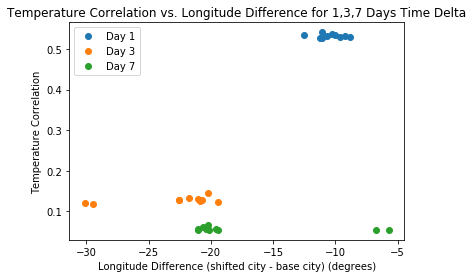

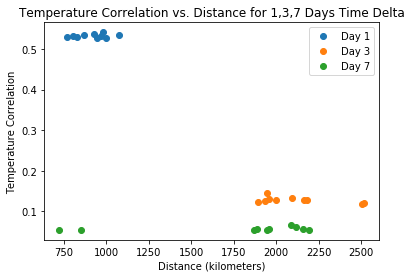

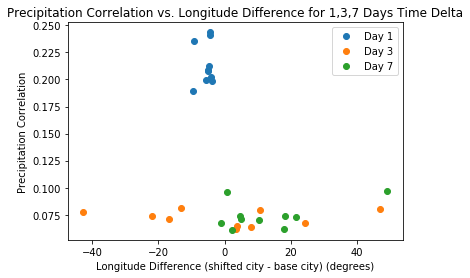

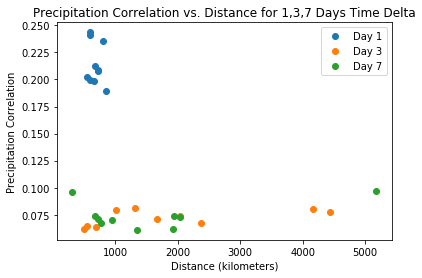

In [46]:
for mode in ['Temperature','Precipitation']:
    make_plots(mode)

<h2>Observations</h2>
<p>
<ul>
<li>Both the precipitation change and temperature change correlations are much stronger 1 day apart than 3 and 7, with 3 and 7 days apart almost having the same overall correlation strengths for precipitation and 3 being stronger than 7 for temperature.</li>
<li>Based on the longitude difference plots, it seems like temperature fronts move towards lower longitude areas (eastward I think), which is pretty interesting. You can also see that the temperature fronts move roughly 10 degrees of longitude per day based on the 1 and 3 day correlation strengths.</li>
<li>Oddly enough, that longitude trend in temperature does not appear in precipitation. It does appear for 1 day correlations but definitely not for 3 or 7 day correlations. The 1 day also appears to suggest that weather fronts move approximately 7-10 degrees of longitude per day.</li>
<li>On the distance plot, we see the same trend as on the longitude plot for 1 day correlations suggesting that 7-10 degrees of longitude difference corresponds to somewhere between 750 and 1000 miles.</li>
<li>The temperature change correlations are in general much more tightly grouped (in both strength of correlation and spread on the x-axis) than the precipitation correlations.</li>
<li>Overall it seems to suggest that temperature change is a mild predictor and has some degeneracy with precipitation change, but precipitation change definitely has other variables influencing it.</li>
</ul>
</p>